This notebook optimizes the threshold for the BDT based on the figure of merit of signal significance

\begin{equation}
\frac{s_i}{\sqrt{s_i+b_i}}
\end{equation}

To avoid biasing ourselves towards data fluctuation, we extract $s_0$ and $b_0$ from a fit for data passing a certain `threshold`, then use BDT efficiencies extracted from application to test data to evaluate

\begin{equation}
s_i=\frac{s_0 \varepsilon_i^s}{\varepsilon_0^s} \\
b_i=\frac{b_0 \varepsilon_i^b}{\varepsilon_0^b}
\end{equation}

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import time
import joblib
import gc
import pylab
import pathlib
from lb2jpsil import fit_utils
from scipy import optimize, integrate
from sklearn import metrics

from mpl_toolkits.axes_grid1 import inset_locator

In [2]:
def MomentumModulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def TransverseMomentumModulus(px, py):
    return np.sqrt(px**2 + py**2)

In [3]:
## Self_explanatory
save_plots = True

## Threshold for preliminary fit for optimization
## Choose one that isn't that high, but shows the signal peak
threshold = 0.49870962

## BDT info
BDTMomenta = 'VF'
BDTSavedStatePath = 'saved_states/BDT_VF_0.05_4_3_1000_0.7.joblib'

## Create plots directory, if missing
plotsDirectory = '/home/adegenna/classifier-studies/plots/BDT/threshold_optimization'
pathlib.Path(plotsDirectory).mkdir(parents=True, exist_ok=True)

# Import Monte Carlo

In [4]:
inputMC = '~/data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

In [5]:
tick = time.perf_counter()
df_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tock = time.perf_counter()
print(f"Monte Carlo imported in {tock - tock:0.4f} seconds.")

Monte Carlo imported in 0.0000 seconds.


In [6]:
tick = time.perf_counter()
df_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tock = time.perf_counter()
print(f"Monte Carlo Truth imported in {tock - tick:0.4f} seconds.")

Monte Carlo Truth imported in 11.3237 seconds.


In [7]:
tick = time.perf_counter()
df_MC = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
tock = time.perf_counter()
print(f"Monte Carlo merged in {tock - tick:0.4f} seconds.")

Monte Carlo merged in 1.0390 seconds.


In [8]:
df_MC = df_MC.loc[(df_MC['MC_key'] >= 0) & (df_MC['Rec_key'] >= 0)]

In [9]:
del(df_truth)
del(df_reco)
gc.collect()

0

## Apply pre-selection cuts

In [10]:
JPsi1SPDGMass = 3096.900

PionPCuts = (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) > 2000) & (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) < 5e5)
ProtonPCuts = (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) > 10000) & (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) < 5e5)
ProtonPTCuts = TransverseMomentumModulus(df_MC['p_PX'], df_MC['p_PY']) > 400
## Combined m(p-pi)? Seems to be "AM" in the DaVinci opt file
LambdaMCuts = (df_MC['L_M'] > 600) & (df_MC['L_M'] < 1500)
LambdaMMCuts = df_MC['L_MM'] < 1500
LambdaZCuts = (df_MC['L_ENDVERTEX_Z'] > 5500) & (df_MC['L_ENDVERTEX_Z'] < 8500)
LambdaDiraCuts = (df_MC['L_BPVDIRA'] > 0.9999)
LambdaBPVIPCHI2Cuts = df_MC['L_BPVIPCHI2'] < 200
LambdaBPVVDCHI2Cuts = df_MC['L_BPVVDCHI2'] < 2e7
LambdaChi2Cuts = df_MC['L_VFASPF_CHI2_VDOF'] < 750
JPsiMCuts = abs(df_MC['Jpsi_M'] - JPsi1SPDGMass) < 90
LambdaPTCuts = TransverseMomentumModulus(df_MC['L_PX'], df_MC['L_PY']) > 450
## Combined m(JpsiLambda)? See comment above
LambdabMCuts = (df_MC['Lb_M'] < 8500)
LambdabDiraCuts = abs(df_MC['Lb_BPVDIRA']) > 0.99
LambdabBPVIPCHI2Cuts = df_MC['Lb_BPVIPCHI2'] < 1750
LambdabChi2Cuts = df_MC['Lb_VFASPF_CHI2_VDOF'] < 150

#DTFCuts = (df_MC['DTF_FixJPsiLambda_status'] == 'Success')

df_MC_Filtered = df_MC.loc[
    PionPCuts &
    ProtonPCuts &
    ProtonPTCuts &
    LambdaMCuts &
    LambdaMMCuts &
    LambdaZCuts &
    LambdaDiraCuts &
    LambdaBPVIPCHI2Cuts &
    LambdaBPVVDCHI2Cuts &
    LambdaChi2Cuts &
    JPsiMCuts &
    LambdaPTCuts &
    LambdabMCuts &
    LambdabDiraCuts &
    LambdabBPVIPCHI2Cuts &
    LambdabChi2Cuts
]

df_MC_Filtered

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.347290,23634.302734,T,0
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375,T,29
8,0.5442,-0.4049,-30.064199,-237.463104,-161.438004,5029.397461,-1999.180054,-1447.800049,43812.398438,-599.280029,...,-151.918823,7139.517578,100.262436,999.515259,50033.699219,-120.737198,-995.344788,6822.337402,T,277
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,104.645416,10220.954102,-884.967468,195.843964,34903.839844,1645.699585,-1113.117432,24484.212891,T,367
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,20.153040,3543.737305,-829.315674,-926.117676,37815.328125,2614.833252,-1553.520630,63936.839844,T,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,1.9930,-0.9682,33.883499,454.162109,-444.944794,6047.499512,7053.950195,-6800.229980,92633.132812,949.369995,...,-1059.302368,13806.107422,2310.392578,-2437.838867,42988.765625,2057.492432,-877.707703,10357.686523,T,8921400
366378,1.2187,-0.0757,-10.080700,120.471603,-69.038300,7221.361328,1256.689941,-628.059998,71476.546875,189.229996,...,-259.237457,19192.976562,1663.037476,477.534760,14450.500000,-812.013245,-604.744568,27734.162109,T,8921503
366382,1.1575,-0.3940,43.910599,4.075100,-146.877396,7409.937500,133.949997,-2934.969971,147684.812500,-69.339996,...,-295.752747,15403.834961,196.509079,-679.625732,6668.261719,3547.472900,-3286.872803,190998.375000,T,8921603


In [11]:
del(df_MC)
gc.collect()

0

# Import dimuon data

In [12]:
inputData = '~/data/Custom_ALL_LHCbData_2016-17-18_MagUpDown_Dimuon_Ttracks.h5'

In [13]:
tick = time.perf_counter()
df_Data = pd.read_hdf(inputData, key='LHCbData')
tock = time.perf_counter()
print(f"Data imported in {tock - tick:0.4f} seconds.")
df_Data

Data imported in 67.0408 seconds.


,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_pim_PZ,DTF_FixJPsiLambda_p_PX,DTF_FixJPsiLambda_p_PY,DTF_FixJPsiLambda_p_PZ,DTF_FixJPsiLambda_mum_PX,DTF_FixJPsiLambda_mum_PY,DTF_FixJPsiLambda_mum_PZ,DTF_FixJPsiLambda_mup_PX,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,6914.724609,-1747.009033,-350.620087,4.244350e+04,-793.366150,54.107079,4428.827637,551.944824,-1187.755859,58498.097656
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,-438873.187500,17554.949219,-1689.618530,-1.096748e+06,-671.020935,-172.458801,11034.705078,3482.218506,-316.173492,44959.343750
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,3323.346436,288.640503,-601.730591,1.581895e+04,-354.302216,850.272766,4830.386719,-2323.214111,-2683.439209,16002.040039
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,4444.798828,86.225441,69.312088,9.542386e+03,1987.955200,506.320618,31560.458984,3073.743896,855.267761,15493.315430
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,10141.857422,-1597.443848,-59.996716,9.855463e+04,-1009.855408,-946.313660,13937.730469,2257.919922,-1761.619263,39306.191406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650399,0.920726,0.124357,-35.697220,-25.280413,-83.092720,5795.710449,0.9197,0.1259,-35.683701,-119.704796,...,42114.628906,-431.172852,-1377.745239,1.006455e+05,-585.858398,-813.267639,37048.574219,-1446.354858,1144.093140,13959.543945
43650400,-0.093952,0.845374,1.271360,-122.958611,-51.635925,8243.633789,-0.0940,0.8450,1.268400,-1565.407349,...,12611.284180,-952.967896,-516.706055,6.764838e+04,853.766968,-604.539368,23576.398438,-1562.600952,1333.469727,23919.253906
43650401,0.025143,-0.081066,45.549873,-122.141373,83.132690,6721.934082,0.0270,-0.0805,45.506199,-3068.416748,...,161458.203125,-1924.491333,1393.570557,9.687066e+04,-6685.428711,-2286.240967,153586.687500,-4194.170410,176.712738,139931.515625
43650402,0.813911,0.249597,10.735976,103.988853,219.124115,6743.214355,0.8164,0.2494,10.746000,527.023315,...,14045.707031,1687.692139,4412.965820,1.459390e+05,400.108704,2005.899536,105752.617188,585.305542,-761.226929,15483.598633


# Integrate missing features
## Monte Carlo

In [14]:
successDictionaryReverse = {
    'Success': 0.0,
    'Failed': 1.0,
    'NonConverged': 3.0
}

In [15]:
df_MC_Filtered = df_MC_Filtered.assign(
    p_PT = TransverseMomentumModulus(df_MC_Filtered['p_PX'],df_MC_Filtered['p_PY']),
    DTF_FixJPsi_p_PT = TransverseMomentumModulus(df_MC_Filtered['DTF_FixJPsi_p_PX'], df_MC_Filtered['DTF_FixJPsi_p_PY']),
    DTF_FixJPsiLambda_p_PT = TransverseMomentumModulus(df_MC_Filtered['DTF_FixJPsiLambda_p_PX'], df_MC_Filtered['DTF_FixJPsiLambda_p_PY']),
    pim_PT = TransverseMomentumModulus(df_MC_Filtered['pim_PX'],df_MC_Filtered['pim_PY']),
    DTF_FixJPsi_pim_PT = TransverseMomentumModulus(df_MC_Filtered['DTF_FixJPsi_pim_PX'], df_MC_Filtered['DTF_FixJPsi_pim_PY']),
    DTF_FixJPsiLambda_pim_PT = TransverseMomentumModulus(df_MC_Filtered['DTF_FixJPsiLambda_pim_PX'], df_MC_Filtered['DTF_FixJPsiLambda_pim_PY']),
    Jpsi_PT = TransverseMomentumModulus(df_MC_Filtered['Jpsi_PX'],df_MC_Filtered['Jpsi_PY'])
)

df_MC_Filtered.replace({'DTF_FixJPsi_status': successDictionaryReverse}, inplace=True)
df_MC_Filtered.replace({'DTF_FixJPsiLambda_status': successDictionaryReverse}, inplace=True)
df_MC_Filtered

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,23634.302734,T,0,3670.964844,2624.076172,2733.329834,311.089020,260.727386,334.741455,1259.644897
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,73489.484375,T,29,962.454834,1039.160889,1095.172607,292.199097,262.192261,278.820038,2350.277832
8,0.5442,-0.4049,-30.064199,-237.463104,-161.438004,5029.397461,-1999.180054,-1447.800049,43812.398438,-599.280029,...,6822.337402,T,277,6069.714355,2933.882812,354.068542,313.657623,496.833252,456.626129,16.075375
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,24484.212891,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,63936.839844,T,493,1088.444824,1386.584595,1326.820923,503.365540,128.678238,192.515366,3060.318604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,1.9930,-0.9682,33.883499,454.162109,-444.944794,6047.499512,7053.950195,-6800.229980,92633.132812,949.369995,...,10357.686523,T,8921400,9575.651367,11972.828125,9594.823242,1461.105103,1673.396362,1428.191162,5488.212402
366378,1.2187,-0.0757,-10.080700,120.471603,-69.038300,7221.361328,1256.689941,-628.059998,71476.546875,189.229996,...,27734.162109,T,8921503,1055.863892,1285.636230,1963.163696,429.001678,345.132141,352.585876,855.027405
366382,1.1575,-0.3940,43.910599,4.075100,-146.877396,7409.937500,133.949997,-2934.969971,147684.812500,-69.339996,...,190998.375000,T,8921603,4872.735840,3059.736816,1022.928284,265.291748,270.466003,294.877197,5446.465820


## Real data

In [16]:
df_Data = df_Data.assign(
    p_PT = TransverseMomentumModulus(df_Data['p_PX'],df_Data['p_PY']),
    DTF_FixJPsi_p_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsi_p_PX'], df_Data['DTF_FixJPsi_p_PY']),
    DTF_FixJPsiLambda_p_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsiLambda_p_PX'], df_Data['DTF_FixJPsiLambda_p_PY']),
    pim_PT = TransverseMomentumModulus(df_Data['pim_PX'],df_Data['pim_PY']),
    DTF_FixJPsi_pim_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsi_pim_PX'], df_Data['DTF_FixJPsi_pim_PY']),
    DTF_FixJPsiLambda_pim_PT = TransverseMomentumModulus(df_Data['DTF_FixJPsiLambda_pim_PX'], df_Data['DTF_FixJPsiLambda_pim_PY']),
    Jpsi_PT = TransverseMomentumModulus(df_Data['Jpsi_PX'],df_Data['Jpsi_PY'])
)

df_Data.replace({'DTF_FixJPsi_status': successDictionaryReverse}, inplace=True)
df_Data.replace({'DTF_FixJPsiLambda_status': successDictionaryReverse}, inplace=True)
df_Data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_mup_PX,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,551.944824,-1187.755859,58498.097656,1525.044067,1.749454e+03,1781.845947,782.852173,321.232666,404.077881,1184.637451
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,3482.218506,-316.173492,44959.343750,521.194397,1.472479e+03,17636.072266,350.746094,2199.127930,7932.257812,2890.091064
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-2323.214111,-2683.439209,16002.040039,562.488403,3.194031e+02,667.377747,243.758881,295.576294,217.761917,3125.168213
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,3073.743896,855.267761,15493.315430,1069.337402,3.339173e+02,110.629982,489.308746,321.725708,177.255829,5212.728516
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,2257.919922,-1761.619263,39306.191406,1070.575562,8.166046e+02,1598.570068,239.489670,241.753296,242.498489,2975.557373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650399,0.920726,0.124357,-35.697220,-25.280413,-83.092720,5795.710449,0.9197,0.1259,-35.683701,-119.704796,...,-1446.354858,1144.093140,13959.543945,1072.377197,8.522087e+02,1443.638428,648.278625,396.158264,615.009827,2050.370361
43650400,-0.093952,0.845374,1.271360,-122.958611,-51.635925,8243.633789,-0.0940,0.8450,1.268400,-1565.407349,...,-1562.600952,1333.469727,23919.253906,1196.969849,1.046630e+03,1084.035522,270.015167,238.809265,245.731079,854.599182
43650401,0.025143,-0.081066,45.549873,-122.141373,83.132690,6721.934082,0.0270,-0.0805,45.506199,-3068.416748,...,-4194.170410,176.712738,139931.515625,2046.022095,1.312916e+03,2376.069336,1600.037231,2380.643555,3373.476807,10682.443359
43650402,0.813911,0.249597,10.735976,103.988853,219.124115,6743.214355,0.8164,0.2494,10.746000,527.023315,...,585.305542,-761.226929,15483.598633,759.683228,2.190097e+07,4724.676758,185.006149,330.289459,583.850281,1565.956665


# Import BDT

In [17]:
tick = time.perf_counter()
BDT = joblib.load(BDTSavedStatePath)
tock = time.perf_counter()
print(f"BDT imported in {(tock - tick):0.4f} seconds.")

BDT imported in 0.0841 seconds.


In [18]:
if BDTMomenta == 'VF':
    pMomenta = ['p_PT', 'p_PZ']
    pimMomenta = ['pim_PT', 'pim_PZ']
elif BDTMomenta == 'DTF':
    pMomenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pimMomenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif BDTMomenta == 'DTFL':
    pMomenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pimMomenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif BDTMomenta == 'NO':
    pMomenta = []
    pimMomenta = []
else:
    raise ValueError(daughterMomenta + " is not a valid option for momenta usage.")

In [19]:
fixedFeatures = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = pMomenta + pimMomenta + fixedFeatures

# Predict event classes
## Monte Carlo

In [20]:
MC_BDT_input = df_MC_Filtered.loc[:, features].to_numpy()

In [21]:
tick = time.perf_counter()
MC_BDT_predictedClasses = BDT.predict_proba(MC_BDT_input)[:,1]
tock = time.perf_counter()
print(f"MC events predicted in {(tock - tick):0.4f} seconds.")

MC events predicted in 1.2263 seconds.


In [22]:
df_MC_Filtered = df_MC_Filtered.assign(
    BDT_output = MC_BDT_predictedClasses,
)

df_MC_Filtered

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,BDT_output
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,T,0,3670.964844,2624.076172,2733.329834,311.089020,260.727386,334.741455,1259.644897,0.994824
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,T,29,962.454834,1039.160889,1095.172607,292.199097,262.192261,278.820038,2350.277832,0.975204
8,0.5442,-0.4049,-30.064199,-237.463104,-161.438004,5029.397461,-1999.180054,-1447.800049,43812.398438,-599.280029,...,T,277,6069.714355,2933.882812,354.068542,313.657623,496.833252,456.626129,16.075375,0.998751
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.997250
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,T,493,1088.444824,1386.584595,1326.820923,503.365540,128.678238,192.515366,3060.318604,0.972917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,1.9930,-0.9682,33.883499,454.162109,-444.944794,6047.499512,7053.950195,-6800.229980,92633.132812,949.369995,...,T,8921400,9575.651367,11972.828125,9594.823242,1461.105103,1673.396362,1428.191162,5488.212402,0.998980
366378,1.2187,-0.0757,-10.080700,120.471603,-69.038300,7221.361328,1256.689941,-628.059998,71476.546875,189.229996,...,T,8921503,1055.863892,1285.636230,1963.163696,429.001678,345.132141,352.585876,855.027405,0.404329
366382,1.1575,-0.3940,43.910599,4.075100,-146.877396,7409.937500,133.949997,-2934.969971,147684.812500,-69.339996,...,T,8921603,4872.735840,3059.736816,1022.928284,265.291748,270.466003,294.877197,5446.465820,0.997543


## Dimuon data

In [23]:
Data_BDT_input = df_Data.loc[:, features].to_numpy()

In [24]:
tick = time.perf_counter()
Data_BDT_predictedClasses = BDT.predict_proba(Data_BDT_input)[:,1]
tock = time.perf_counter()
print(f"Dimuon data events predicted in {(tock - tick):0.4f} seconds.")

Dimuon data events predicted in 738.0438 seconds.


In [25]:
df_Data = df_Data.assign(
    BDT_output = Data_BDT_predictedClasses,
)

df_Data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,BDT_output
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,-1187.755859,58498.097656,1525.044067,1.749454e+03,1781.845947,782.852173,321.232666,404.077881,1184.637451,0.009959
1,0.819310,-0.207494,-12.258046,-82.289032,-16.596403,6057.988770,0.8168,-0.2077,-12.286400,-1174.547974,...,-316.173492,44959.343750,521.194397,1.472479e+03,17636.072266,350.746094,2199.127930,7932.257812,2890.091064,0.000076
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-2683.439209,16002.040039,562.488403,3.194031e+02,667.377747,243.758881,295.576294,217.761917,3125.168213,0.005811
3,0.974854,-0.085595,20.542496,-32.013988,97.482521,6381.826660,0.9740,-0.0862,20.537600,-520.050232,...,855.267761,15493.315430,1069.337402,3.339173e+02,110.629982,489.308746,321.725708,177.255829,5212.728516,0.000470
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,-1761.619263,39306.191406,1070.575562,8.166046e+02,1598.570068,239.489670,241.753296,242.498489,2975.557373,0.821073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650399,0.920726,0.124357,-35.697220,-25.280413,-83.092720,5795.710449,0.9197,0.1259,-35.683701,-119.704796,...,1144.093140,13959.543945,1072.377197,8.522087e+02,1443.638428,648.278625,396.158264,615.009827,2050.370361,0.002868
43650400,-0.093952,0.845374,1.271360,-122.958611,-51.635925,8243.633789,-0.0940,0.8450,1.268400,-1565.407349,...,1333.469727,23919.253906,1196.969849,1.046630e+03,1084.035522,270.015167,238.809265,245.731079,854.599182,0.004535
43650401,0.025143,-0.081066,45.549873,-122.141373,83.132690,6721.934082,0.0270,-0.0805,45.506199,-3068.416748,...,176.712738,139931.515625,2046.022095,1.312916e+03,2376.069336,1600.037231,2380.643555,3373.476807,10682.443359,0.010692
43650402,0.813911,0.249597,10.735976,103.988853,219.124115,6743.214355,0.8164,0.2494,10.746000,527.023315,...,-761.226929,15483.598633,759.683228,2.190097e+07,4724.676758,185.006149,330.289459,583.850281,1565.956665,0.000867


In [26]:
del(MC_BDT_predictedClasses)
del(Data_BDT_predictedClasses)
gc.collect()

0

# Explore selected events

In [27]:
## Takes as input a hexstring (doesn't care if with or without the leading hash)
## and an alpha value. Yields a tuple for matplotlib color definition
def HexToRGBA(hexstring, alpha):
    if hexstring[0] == '#':
        hexstring = hexstring[1:]
    
    #return tuple(int(hexstring[i:i+2], 16) for i in (0, 2, 4))
    return list(int(hexstring[i:i+2], 16)/255 for i in (0, 2, 4)) + [alpha]

In [28]:
plum = '#6e304b'
apricot = '#e2ae6c'
lightplum = '#a37c82'

In [29]:
invariantMassVariable = 'DTF_FixJPsiLambda_Lb_M'
invariantMassVariableTitle = '$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)'

lambdabPDGMass = 5620.2

MC_thresholdCondition = df_MC_Filtered['BDT_output'] > threshold
Data_thresholdCondition = df_Data['BDT_output'] > threshold
thresholdLabel = "BDT > " + str(threshold)[:6]

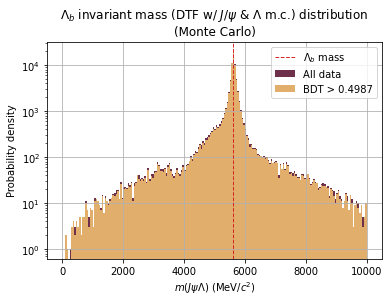

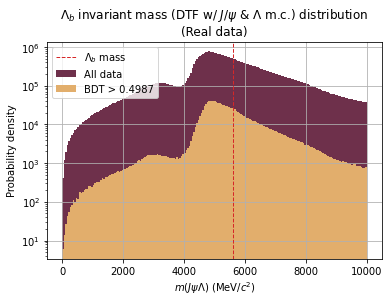

In [30]:
massRange = (0, 10000)
binNumber = 200
plotFileTemplate = 'lambdab_mass_distribution_selection'

plotFileName = 'MC_' + plotFileTemplate

plt.hist(df_MC_Filtered[invariantMassVariable], color=plum,
         bins=binNumber, range=massRange, label='All data')
plt.hist(df_MC_Filtered.loc[MC_thresholdCondition, invariantMassVariable], color=apricot,
         bins=binNumber, range=massRange, label=thresholdLabel)
plt.grid()
plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Probability density')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

plotFileName = 'Data_' + plotFileTemplate

plt.hist(df_Data[invariantMassVariable], color=plum,
         bins=binNumber, range=massRange, label='All data')
plt.hist(df_Data.loc[Data_thresholdCondition, invariantMassVariable], color=apricot,
         bins=binNumber, range=massRange, label=thresholdLabel)
plt.grid()
plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Probability density')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

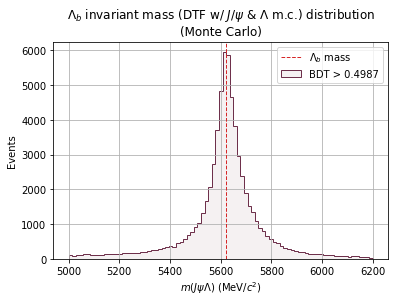

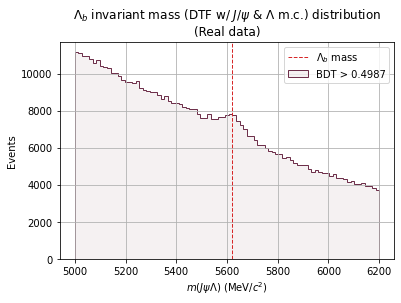

In [31]:
massRange = (5000, 6200)
binNumber = 85
plotFileTemplate = 'lambdab_mass_distribution_after_selection'

plotFileName = 'MC_' + plotFileTemplate

MC_events, MC_bins, MC_patches = plt.hist(
    df_MC_Filtered.loc[MC_thresholdCondition, invariantMassVariable],
    histtype='stepfilled', color=HexToRGBA(lightplum,0.1), edgecolor=plum,
    bins=binNumber, range=massRange, label=thresholdLabel)

plt.grid()
#plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

plotFileName = 'Data_' + plotFileTemplate

data_events, data_bins, data_patches = plt.hist(
    df_Data.loc[Data_thresholdCondition, invariantMassVariable],
    histtype='stepfilled', color=HexToRGBA(lightplum,0.1), edgecolor=plum,
    bins=binNumber, range=massRange, label=thresholdLabel)

plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

# Monte Carlo signal-only fit
First we perform a fit to selected Monte Carlo events. Normalization notwithstanding, we'll constrain the signal fit on real data to the results obtained here.

In [32]:
## Almost zero, but not quite
epsilon = 1e-15

## Double crystal ball parameter dictionary
signalFunctionDictionary = {
     'param_names' : [r'S'  , r'mu' , r'sigma', r'alpha_1', r'n_1', r'alpha_2', r'n_2'],
     'p0'          : [6e4   , 5618   ,  35      , 0.7        ,  3.7  , 0.7        ,    3.7],
     'lb'          : [1e1   , 5000   ,   1      , 0.1        ,  1.5  , 0.1        ,    1.5],
     'ub'          : [1e6   , 6250   , 200      , 5          ,   10  , 5          ,     10]
}

## Dictionary variant for the constrained sig+bkg fit
constrainedSignalFunctionDictionary = {
     'param_names' : [ r'S' ],
     'p0'          : [  200 ],
     'lb'          : [    0 ],
     'ub'          : [  1e9 ]
}

backgroundFunctionDictionary = {
    'param_names' : [r'C',    r'm_0', r'a'],
    'p0' :          [0.09,    3500,   0.0008 ],
    'lb' :          [epsilon, 0,      epsilon],
    'ub' :          [1e9,     4999,   1      ]
}

In [33]:
MC_binMidpoints = (MC_bins[1:] + MC_bins[:-1]) / 2

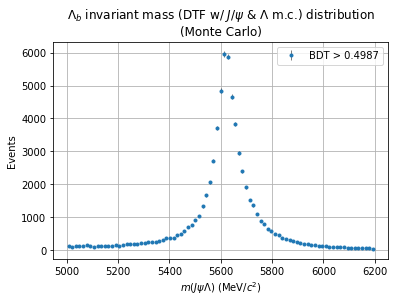

In [34]:
plotFileName = 'MC_lambdab_mass_distribution_histogrammed'

plt.errorbar(x=MC_binMidpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=thresholdLabel)
plt.grid()
plt.title(invariantMassVariableTitle + " distribution" + '\n(Monte Carlo)')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

In [35]:
MC_bestParameters, MC_covarianceMatrix = optimize.curve_fit(
    f=fit_utils.crystal_ball_double_norm,
    xdata=MC_binMidpoints,
    ydata=MC_events,
    p0=signalFunctionDictionary['p0'],
    sigma=np.sqrt(MC_events),
    bounds=(
        signalFunctionDictionary['lb'],
        signalFunctionDictionary['ub']
    )
)

In [36]:
MC_parameterNames = signalFunctionDictionary['param_names']
MC_parameterErrors = np.sqrt(np.diag(MC_covarianceMatrix))
for name, bestValue, error in zip(MC_parameterNames, MC_bestParameters, MC_parameterErrors):
    print(name, ":", bestValue, "+-", error)

S : 999999.9999991508 +- 9768.929105885565
mu : 5619.988235264834 +- 0.5808078497231
sigma : 34.481774025387004 +- 1.2271038725600882
alpha_1 : 0.9111719757289948 +- 0.033330194229987925
n_1 : 1.710542188714258 +- 0.05863439618845776
alpha_2 : 0.6557094062262822 +- 0.027874027520005937
n_2 : 3.3323538590804573 +- 0.1563929765445298


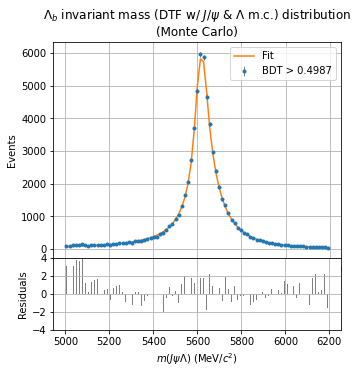

In [37]:
plotFileName = 'MC_lambdab_mass_distribution_histogrammed_fitted'

fig1 = plt.figure(figsize=(5, 5))

frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(x=MC_binMidpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='', marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=thresholdLabel)
plt.plot(MC_binMidpoints,
         fit_utils.crystal_ball_double_norm(MC_binMidpoints, *MC_bestParameters),
         color='tab:orange',
         label='Fit')
plt.grid()
plt.title(invariantMassVariableTitle + " distribution" + '\n(Monte Carlo)')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend()

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.bar(x=MC_binMidpoints,
        height=(MC_events - fit_utils.crystal_ball_double_norm(MC_binMidpoints, *MC_bestParameters))/np.sqrt(MC_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Residuals")
plt.yticks([-4,-2,0,2,4])
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

In [38]:
(
    mu_Constrained,
    sigma_Constrained,
    alpha_1_Constrained,
    n_1_Constrained,
    alpha_2_Constrained,
    n_2_Constrained
) = MC_bestParameters[1:]

# Data signal + background fit

In [39]:
data_binMidpoints = (data_bins[1:] + data_bins[:-1]) / 2

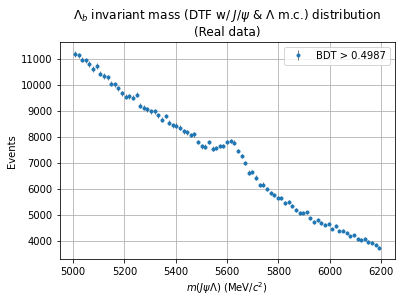

In [40]:
plotFileName = 'Data_lambdab_mass_distribution_histogrammed'

plt.errorbar(x=data_binMidpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=thresholdLabel)
plt.grid()
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

In [41]:
## This is the fit function, sum of:
## 1. A crystal_ball_double_norm with fixed parameters apart from normalization S (derived from data fit).
## 2. A turn_on_exp with free parameters C (normalization), m_0 (turn-on mass), a (coefficient, as in exp[-a*x])
def InvariantMassFitFunction(x, S, C, m0, a):
    ## Fixed parameters
    mu = mu_Constrained
    sigma = sigma_Constrained
    alpha1 = alpha_1_Constrained
    n1 = n_1_Constrained
    alpha2 = alpha_2_Constrained
    n2 = n_2_Constrained
    
    signal = fit_utils.crystal_ball_double_norm(x, S, mu, sigma, alpha1, n1, alpha2, n2)
    background = fit_utils.turn_on_exp(x, C, m0, a)
    
    return signal + background

In [42]:
data_bestParameters, data_covarianceMatrix = optimize.curve_fit(
    f=InvariantMassFitFunction,
    xdata=data_binMidpoints,
    ydata=data_events,
    p0=constrainedSignalFunctionDictionary['p0']+backgroundFunctionDictionary['p0'],
    sigma=np.sqrt(data_events),
    bounds=(
        constrainedSignalFunctionDictionary['lb']+backgroundFunctionDictionary['lb'],
        constrainedSignalFunctionDictionary['ub']+backgroundFunctionDictionary['ub']
    )
)

In [43]:
data_parameterNames = constrainedSignalFunctionDictionary['param_names'] + backgroundFunctionDictionary['param_names']
data_parameterErrors = np.sqrt(np.diag(data_covarianceMatrix))
for name, bestValue, error in zip(data_parameterNames, data_bestParameters, data_parameterErrors):
    print(name, ":", bestValue, "+-", error)

S : 190071.44129454618 +- 9114.217028915351
C : 1059.7301228170945 +- 19.332224953073613
m_0 : 4363.585611760021 +- 41.5556627844884
a : 0.001369436641918222 +- 1.7323539196832684e-05


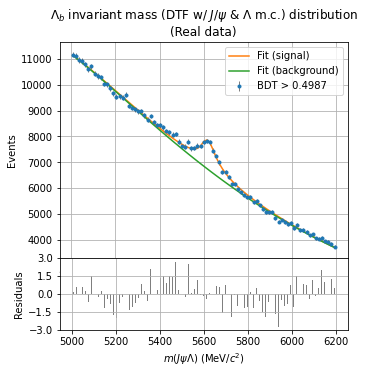

In [44]:
plotFileName = 'Data_lambdab_mass_distribution_histogrammed_fitted'

fig1 = plt.figure(figsize=(5, 5))

frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_binMidpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='', marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=thresholdLabel)
plt.plot(data_binMidpoints,
         InvariantMassFitFunction(data_binMidpoints, *data_bestParameters), color='tab:orange', label='Fit (signal)')
plt.plot(data_binMidpoints,
         fit_utils.turn_on_exp(data_binMidpoints, *data_bestParameters[1:]), color='tab:green', label='Fit (background)')
plt.grid()
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend()

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.bar(x=data_binMidpoints,
        height=(data_events - InvariantMassFitFunction(data_binMidpoints, *data_bestParameters))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-3,3))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Residuals")
plt.yticks([-3,-1.5,0,1.5,3])
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

# "Integrate" to extract $s_0$ and $b_0$
We don't actually integrate, more so we predict the number of events in a certain bin by evaluating the fit function in the bin midpoint. This isn't the best estimate, but what we want is a rough estimate of the number of events above a threshold.

In [45]:
S, C, m0, a = data_bestParameters

lowerLimit = mu_Constrained - 2.5 * sigma_Constrained
upperLimit = mu_Constrained + 2.5 * sigma_Constrained

print("Integration interval:", (lowerLimit, upperLimit))

Integration interval: (5533.783800201366, 5706.192670328302)


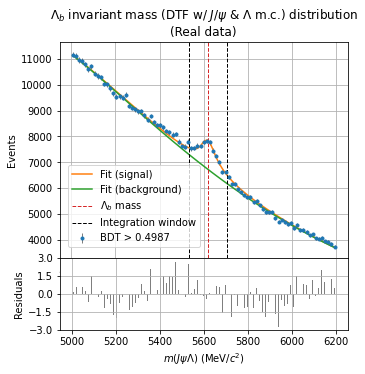

In [46]:
plotFileName = 'Data_lambdab_mass_distribution_histogrammed_fitted_withdetails'

fig1 = plt.figure(figsize=(5, 5))

frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_binMidpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='', marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=thresholdLabel)
plt.plot(data_binMidpoints,
         InvariantMassFitFunction(data_binMidpoints, *data_bestParameters), color='tab:orange', label='Fit (signal)')
plt.plot(data_binMidpoints,
         fit_utils.turn_on_exp(data_binMidpoints, *data_bestParameters[1:]), color='tab:green', label='Fit (background)')
plt.grid()
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.axvline(lambdabPDGMass, linestyle='--', color='tab:red', linewidth=1, label='$\Lambda_b$ mass')
plt.axvline(lowerLimit, linestyle='--', color='k', linewidth=1)
plt.axvline(upperLimit, linestyle='--', color='k', linewidth=1, label='Integration window')
plt.legend(loc=(.03,.05))

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.bar(x=data_binMidpoints,
        height=(data_events - InvariantMassFitFunction(data_binMidpoints, *data_bestParameters))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-3,3))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Residuals")
plt.yticks([-3,-1.5,0,1.5,3])
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

In [47]:
integrationWindow = (data_binMidpoints >= lowerLimit) & (data_binMidpoints <= upperLimit)

s0 = sum(fit_utils.crystal_ball_double_norm(
    data_binMidpoints[integrationWindow],
    S, mu_Constrained, sigma_Constrained, alpha_1_Constrained, n_1_Constrained, alpha_2_Constrained, n_2_Constrained
))
b0 = sum(fit_utils.turn_on_exp(data_binMidpoints[integrationWindow], C, m0, a))

print("s0 =", s0, "\nb0 =", b0)

s0 = 7978.0335693359375 
b0 = 80636.44189453125


# Compute BDT efficiencies from test data
To avoid bias (and to make our life easier), we use the efficiencies determined from the testing data through computation of the ROC curve.

In [48]:
inputTest = '~/classifier-studies/data/testData.h5'
df_Test = pd.read_hdf(inputTest, 'LHCb_Test')

In [49]:
Test_BDT_input = df_Test.loc[:, features].to_numpy()
Test_BDT_classes = df_Test.loc[:, 'TYPE'].to_numpy()

In [50]:
#Y_test_predicted = BDT.predict(X_test)
Test_BDT_predictedClasses = BDT.predict_proba(Test_BDT_input)[:,1]

In [51]:
falsePositiveRates, truePositiveRates, thresholds = metrics.roc_curve(Test_BDT_classes, Test_BDT_predictedClasses)

In [52]:
df_Test_ThresholdEfficiencies = pd.DataFrame(
    {
        'threshold': thresholds,
        'sig_eff': truePositiveRates,
        'bkg_eff': falsePositiveRates
    }
)

df_Test_ThresholdEfficiencies.sort_values(by='threshold', inplace=True)
df_Test_ThresholdEfficiencies

,threshold,sig_eff,bkg_eff
1348,0.000009,1.000000,1.000000
1347,0.000140,1.000000,0.959635
1346,0.000140,0.999876,0.959635
1345,0.003082,0.999876,0.457874
1344,0.003083,0.999752,0.457874
...,...,...,...
4,0.997074,0.213799,0.000173
3,0.997075,0.213799,0.000115
2,0.999995,0.000000,0.000115
1,1.000000,0.000000,0.000058


To use the FOM we need to know the signal/background efficiencies for the preliminary threshold cut we used. Generally speaking we won't have the exact value, but we can get the next best thing: the closest efficiency computed in the ROC score.

In [53]:
closestEfficiencies = df_Test_ThresholdEfficiencies.iloc[
    (df_Test_ThresholdEfficiencies['threshold']-threshold).abs().argsort()[:1]
].to_numpy()[0]

signalReverseEfficiency = closestEfficiencies[1]
backgroundReverseEfficiency = closestEfficiencies[2]

In [54]:
def SignalEfficiency(s0, b0):
    return s0 / np.sqrt(s0 + b0)

In [55]:
df_Test_ThresholdEfficiencies = df_Test_ThresholdEfficiencies.assign(
    sig_events = s0 * df_Test_ThresholdEfficiencies['sig_eff'] / signalReverseEfficiency,
    bkg_events = b0 * df_Test_ThresholdEfficiencies['bkg_eff'] / backgroundReverseEfficiency
)

df_Test_ThresholdEfficiencies = df_Test_ThresholdEfficiencies.assign(
    sig_significance = SignalEfficiency(df_Test_ThresholdEfficiencies['sig_events'], df_Test_ThresholdEfficiencies['bkg_events'])
)

df_Test_ThresholdEfficiencies

,threshold,sig_eff,bkg_eff,sig_events,bkg_events,sig_significance
1348,0.000009,1.000000,1.000000,8461.201393,3.103069e+06,4.796727
1347,0.000140,1.000000,0.959635,8461.201393,2.977814e+06,4.896290
1346,0.000140,0.999876,0.959635,8460.153307,2.977814e+06,4.895684
1345,0.003082,0.999876,0.457874,8460.153307,1.420814e+06,7.076532
1344,0.003083,0.999752,0.457874,8459.105220,1.420814e+06,7.075657
...,...,...,...,...,...,...
4,0.997074,0.213799,0.000173,1808.997102,5.375763e+02,37.343997
3,0.997075,0.213799,0.000115,1808.997102,3.583842e+02,38.857084
2,0.999995,0.000000,0.000115,0.000000,3.583842e+02,0.000000
1,1.000000,0.000000,0.000058,0.000000,1.791921e+02,0.000000


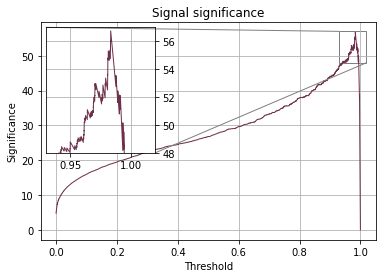

In [56]:
plotFileName = 'signal_significance'

fig, ax = plt.subplots(figsize=[6,4])

## Global plot
ax.plot(df_Test_ThresholdEfficiencies['threshold'],
         df_Test_ThresholdEfficiencies['sig_significance'],
         color=plum, linewidth=1)
plt.title("Signal significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.grid()

## Zoomed inset plot
axins = inset_locator.zoomed_inset_axes(ax, 4, loc='upper left') # zoom = 6
axins.plot(df_Test_ThresholdEfficiencies['threshold'],
         df_Test_ThresholdEfficiencies['sig_significance'],
         color=plum, linewidth=1)
x1, x2, y1, y2 = 0.93, 1.02, 48, 57
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.tick_params(
    axis='both',
    which='both',
    right=True,
    left=False,
    labelleft=False,
    labelright=True,
    direction='out'
)
plt.xticks(ticks=[.95,1])
#plt.yticks(ticks=[40, 50, 60], labels=['40', '50', '60'])
plt.grid()
inset_locator.mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

In [57]:
df_Test_ThresholdEfficiencies.sort_values(by='sig_significance', ascending=False)

,threshold,sig_eff,bkg_eff,sig_events,bkg_events,sig_significance
21,0.983275,0.543664,0.000635,4600.051148,1.971113e+03,56.746816
23,0.983131,0.544779,0.000693,4609.483925,2.150305e+03,56.064213
22,0.983266,0.543664,0.000693,4600.051148,2.150305e+03,55.988562
25,0.983027,0.546513,0.000751,4624.157135,2.329497e+03,55.453126
24,0.983131,0.544779,0.000751,4609.483925,2.329497e+03,55.335578
...,...,...,...,...,...,...
1346,0.000140,0.999876,0.959635,8460.153307,2.977814e+06,4.895684
1348,0.000009,1.000000,1.000000,8461.201393,3.103069e+06,4.796727
2,0.999995,0.000000,0.000115,0.000000,3.583842e+02,0.000000
1,1.000000,0.000000,0.000058,0.000000,1.791921e+02,0.000000


In [58]:
series_bestThreshold = df_Test_ThresholdEfficiencies.loc[df_Test_ThresholdEfficiencies['sig_significance'].idxmax()]
series_bestThreshold

threshold              0.983275
sig_eff                0.543664
bkg_eff                0.000635
sig_events          4600.051148
bkg_events          1971.113024
sig_significance      56.746816
Name: 21, dtype: float64

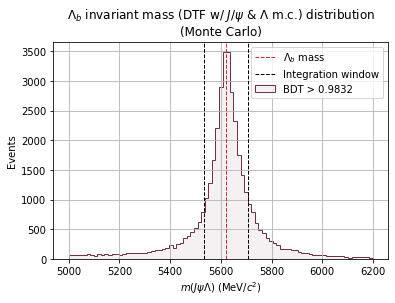

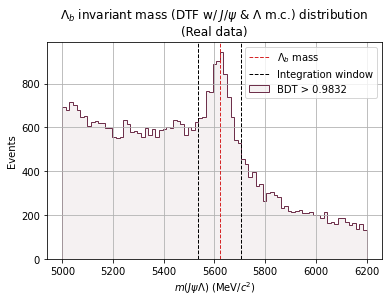

In [59]:
massRange = (5000, 6200)
binNumber = 85
bestThreshold = series_bestThreshold['threshold']
plotFileTemplate = 'lambdab_mass_distribution_after_selection_best-threshold'

plotFileName = 'MC_' + plotFileTemplate

MC_bestThresholdCondition = df_MC_Filtered['BDT_output'] > bestThreshold
Data_bestThresholdCondition = df_Data['BDT_output'] > bestThreshold
bestThresholdLabel = "BDT > " + str(bestThreshold)[:6]

bestT_MC_events, bestT_MC_bins, bestT_MC_patches = plt.hist(
    df_MC_Filtered.loc[MC_bestThresholdCondition, invariantMassVariable],
    histtype='stepfilled', color=HexToRGBA(lightplum,0.1), edgecolor=plum,
    bins=binNumber, range=massRange, label=bestThresholdLabel)

plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.axvline(lowerLimit, linestyle='--', color='k', linewidth=1)
plt.axvline(upperLimit, linestyle='--', color='k', linewidth=1, label='Integration window')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

plotFileName = 'Data_' + plotFileTemplate

bestT_data_events, bestT_data_bins, bestT_data_patches = plt.hist(
    df_Data.loc[Data_bestThresholdCondition, invariantMassVariable],
    histtype='stepfilled', color=HexToRGBA(lightplum,0.1), edgecolor=plum,
    bins=binNumber, range=massRange, label=bestThresholdLabel)

plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.axvline(lambdabPDGMass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.axvline(lowerLimit, linestyle='--', color='k', linewidth=1)
plt.axvline(upperLimit, linestyle='--', color='k', linewidth=1, label='Integration window')
plt.legend()
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

In [60]:
bestT_data_binMidpoints = (bestT_data_bins[1:] + bestT_data_bins[:-1]) / 2

In [61]:
bestT_data_bestParameters, bestT_data_covarianceMatrix = optimize.curve_fit(
    f=InvariantMassFitFunction,
    xdata=bestT_data_binMidpoints,
    ydata=bestT_data_events,
    p0=constrainedSignalFunctionDictionary['p0']+backgroundFunctionDictionary['p0'],
    sigma=np.sqrt(bestT_data_events),
    bounds=(
        constrainedSignalFunctionDictionary['lb']+backgroundFunctionDictionary['lb'],
        constrainedSignalFunctionDictionary['ub']+backgroundFunctionDictionary['ub']
    )
)

In [62]:
bestT_data_parameterNames = constrainedSignalFunctionDictionary['param_names'] + backgroundFunctionDictionary['param_names']
bestT_data_parameterErrors = np.sqrt(np.diag(bestT_data_covarianceMatrix))
for name, bestValue, error in zip(bestT_data_parameterNames, bestT_data_bestParameters, bestT_data_parameterErrors):
    print(name, ":", bestValue, "+-", error)

S : 105779.88603148353 +- 4330.592837098014
C : 72.46053072065051 +- 1.5364237527763505
m_0 : 4857.1551454220125 +- 27.210297288243794
a : 0.002242009303025883 +- 6.111739621453208e-05


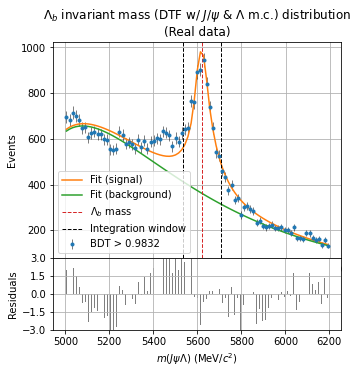

In [63]:
plotFileName = 'Data_lambdab_mass_distribution_histogrammed_fitted_best-threshold'

fig1 = plt.figure(figsize=(5, 5))

frame1=fig1.add_axes((.1,.3,.8,.6))
plt.errorbar(x=bestT_data_binMidpoints,
             y=bestT_data_events,
             yerr=np.sqrt(bestT_data_events),
             linestyle='', marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=bestThresholdLabel)
plt.plot(bestT_data_binMidpoints,
         InvariantMassFitFunction(bestT_data_binMidpoints, *bestT_data_bestParameters), color='tab:orange', label='Fit (signal)')
plt.plot(bestT_data_binMidpoints,
         fit_utils.turn_on_exp(bestT_data_binMidpoints, *bestT_data_bestParameters[1:]), color='tab:green', label='Fit (background)')
plt.grid()
plt.title(invariantMassVariableTitle + " distribution" + '\n(Real data)')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.axvline(lambdabPDGMass, linestyle='--', color='tab:red', linewidth=1, label='$\Lambda_b$ mass')
plt.axvline(lowerLimit, linestyle='--', color='k', linewidth=1)
plt.axvline(upperLimit, linestyle='--', color='k', linewidth=1, label='Integration window')
plt.legend(loc=3)

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.bar(x=bestT_data_binMidpoints,
        height=(bestT_data_events - InvariantMassFitFunction(bestT_data_binMidpoints, *bestT_data_bestParameters))/np.sqrt(bestT_data_events),
        width=4,
        color='tab:gray')
plt.ylim((-3,3))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Residuals")
plt.yticks([-3,-1.5,0,1.5,3])
if save_plots:
    plt.savefig(plotsDirectory + '/' + plotFileName + '.pdf', bbox_inches='tight')
plt.show()

In [64]:
bestT_S, bestT_C, bestT_m0, bestT_a = bestT_data_bestParameters

In [65]:
bestT_Sig = sum(fit_utils.crystal_ball_double_norm(
    bestT_data_binMidpoints[integrationWindow],
    bestT_S, mu_Constrained, sigma_Constrained, alpha_1_Constrained, n_1_Constrained, alpha_2_Constrained, n_2_Constrained
))
bestT_Bkg = sum(fit_utils.turn_on_exp(bestT_data_binMidpoints[integrationWindow], bestT_C, bestT_m0, bestT_a))

print("Signal events =", bestT_Sig, "\nBackground events =", bestT_Bkg)

Signal events = 4439.990936279297 
Background events = 4342.763641357422
